In [6]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from numpy import pi

In [132]:
from qiskit import IBMQ

provider = IBMQ.load_account()
my_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backends = my_provider.backends()

for backend in backends:
    print(backend) # only available for 7-qubit device

ibmqfactory.load_account:WARNING:2023-04-11 14:17:52,619: Credentials are already in use. The existing account in the session will be replaced.


ibmq_qasm_simulator
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_jakarta
ibmq_manila
ibm_lagos
ibm_nairobi
ibm_perth
ibm_oslo


In [7]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [8]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [9]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [19]:
qc = QuantumCircuit(3, 3)

qc.x(1)

qc.barrier()
qft(qc,3)
qc.barrier()
qc.measure(range(3), range(3))
qc.draw()

░                                      ┌───┐    ░ ┌─┐      
q_0: ──────░───────■──────────────────────■───────┤ H ├─X──░─┤M├──────
     ┌───┐ ░       │                ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐   
q_1: ┤ X ├─░───────┼────────■───────┤ H ├─■─────────────┼──░──╫─┤M├───
     └───┘ ░ ┌───┐ │P(π/4)  │P(π/2) └───┘               │  ░  ║ └╥┘┌─┐
q_2: ──────░─┤ H ├─■────────■───────────────────────────X──░──╫──╫─┤M├
           ░ └───┘                                         ░  ║  ║ └╥┘
c: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2

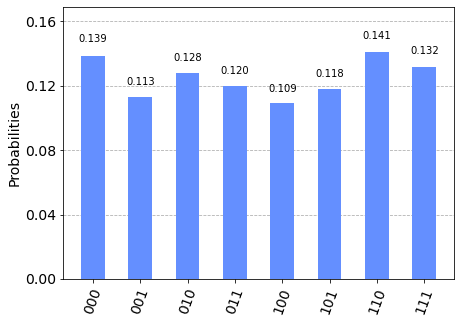

In [20]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)
qobj = assemble(qc_transpiled)

results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [21]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [103]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [104]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

{'101': 1024}


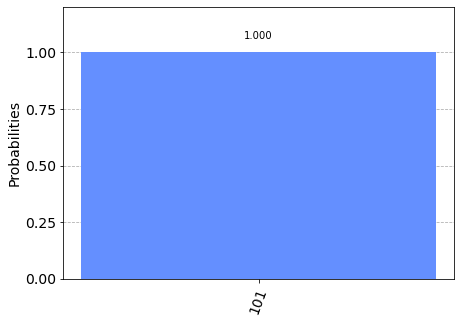

In [105]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)
qobj = assemble(qc_transpiled)

results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 32
{'000': 122, '001': 748, '010': 118, '011': 365, '100': 370, '101': 1938, '110': 130, '111': 209}


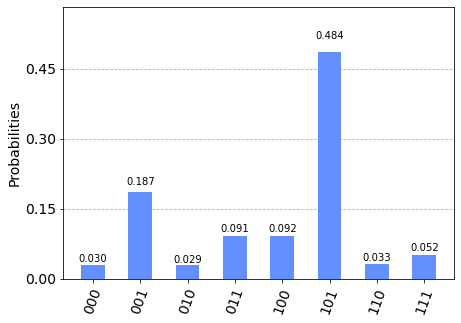

In [107]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_perth')
qc_perth = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_perth.depth())
results = backend.run(qc_perth).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 32
{'000': 184, '001': 801, '010': 61, '011': 310, '100': 539, '101': 1910, '110': 69, '111': 126}


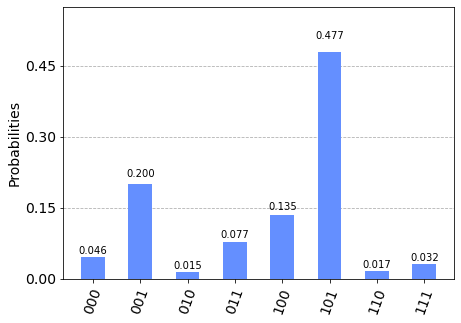

In [108]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_nairobi')
qc_nairobi = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_nairobi.depth())
results = backend.run(qc_nairobi).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 87, '001': 627, '010': 24, '011': 165, '100': 89, '101': 2507, '110': 72, '111': 429}


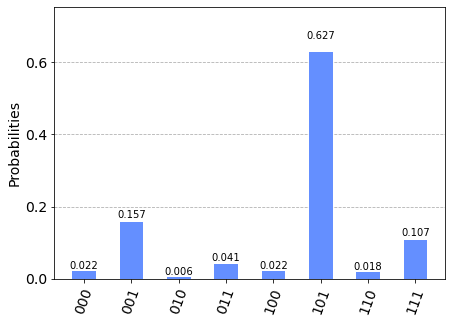

In [109]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_oslo')
qc_oslo = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_oslo.depth())
results = backend.run(qc_oslo).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 33
{'000': 80, '001': 293, '010': 107, '011': 409, '100': 268, '101': 2299, '110': 154, '111': 390}


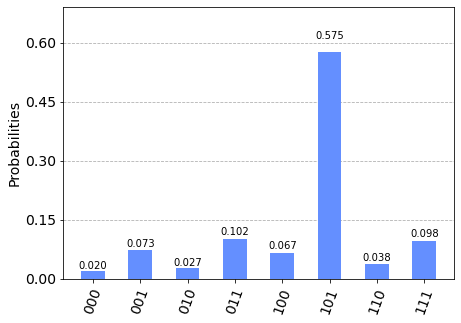

In [111]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_jakarta')
qc_jakarta = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,5])

print("Circuit Depth :", qc_jakarta.depth())
results = backend.run(qc_jakarta).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 32
{'000': 83, '001': 457, '010': 37, '011': 63, '100': 179, '101': 2794, '110': 158, '111': 229}


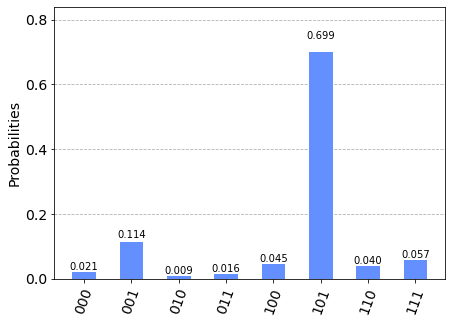

In [112]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_manila')
qc_manila = transpile(qc, backend, optimization_level=2, initial_layout=[2,3,4])

print("Circuit Depth :", qc_manila.depth())
results = backend.run(qc_manila).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 29
{'000': 78, '001': 264, '010': 48, '011': 361, '100': 337, '101': 2444, '110': 101, '111': 367}


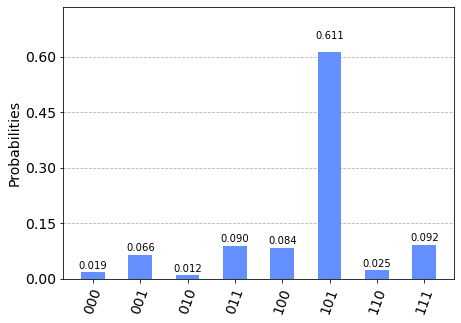

In [117]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_quito')
qc_quito = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_quito.depth())
results = backend.run(qc_quito).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 32
{'000': 141, '001': 454, '010': 78, '011': 208, '100': 343, '101': 2402, '110': 177, '111': 197}


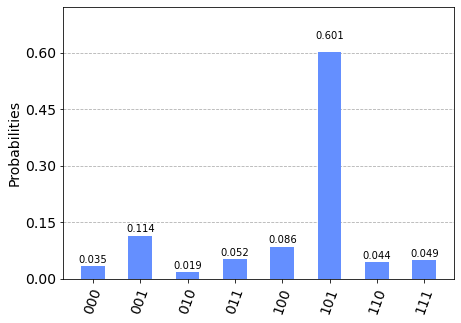

In [115]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_belem')
qc_belem = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_belem.depth())
results = backend.run(qc_belem).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 33
{'000': 179, '001': 748, '010': 73, '011': 302, '100': 278, '101': 1941, '110': 143, '111': 336}


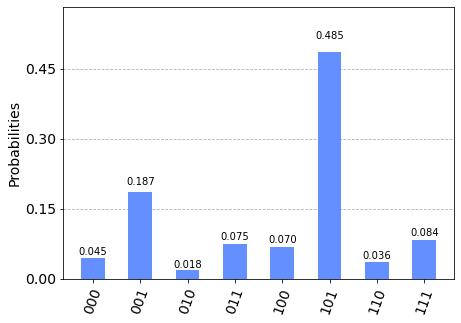

In [116]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_lima')
qc_lima = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4])

print("Circuit Depth :", qc_lima.depth())
results = backend.run(qc_lima).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

In [118]:
number = 5
qc = QuantumCircuit(5)
qc.h([0,3,4])
qc.p(number*pi/4,0)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     └───┘└─────────┘
q_1: ────────────────
                     
q_2: ────────────────
     ┌───┐┌─────────┐
q_3: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_4: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [119]:
# Encode
qc.cx(0,1)

# CCX_L
qc.ccx(0,1,4)

# CXX_L
qc.cx(4,0)
qc.cx(4,1)

# CCX_L
qc.ccx(0,1,4)

# H_L
qc.h(1)
qc.cry(pi,1,0)
qc.h([0,1])

# CP_L
qc.mcp(-pi/2, [0,1], 3)
qc.h(3)

# CP_L
qc.mcp(-pi/4, [0,1], 4)
qc.cp(-pi/2,3,4)
qc.h(4)

# EF
qc.cx(0,2)
qc.cx(1,2)

qc.measure_all()
qc.draw()

┌───┐┌─────────┐          ┌───┐               ┌───────┐┌───┐          »
   q_0: ┤ H ├┤ P(5π/4) ├──■────■──┤ X ├───────■───────┤ Ry(π) ├┤ H ├─■────────»
        └───┘└─────────┘┌─┴─┐  │  └─┬─┘┌───┐  │  ┌───┐└───┬───┘├───┤ │        »
   q_1: ────────────────┤ X ├──■────┼──┤ X ├──■──┤ H ├────■────┤ H ├─■────────»
                        └───┘  │    │  └─┬─┘  │  └───┘         └───┘ │        »
   q_2: ───────────────────────┼────┼────┼────┼──────────────────────┼────────»
        ┌───┐┌─────────┐       │    │    │    │                      │P(-π/2) »
   q_3: ┤ H ├┤ P(5π/2) ├───────┼────┼────┼────┼──────────────────────■────────»
        ├───┤└┬───────┬┘     ┌─┴─┐  │    │  ┌─┴─┐                             »
   q_4: ┤ H ├─┤ P(5π) ├──────┤ X ├──■────■──┤ X ├─────────────────────────────»
        └───┘ └───────┘      └───┘          └───┘                             »
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                                       ░ ┌─┐            
«   q_0: ──────■────────────■───────────░─┤M├────────────
«              │            │           ░ └╥┘┌─┐         
«   q_1: ──────■────────────┼───────■───░──╫─┤M├─────────
«              │          ┌─┴─┐   ┌─┴─┐ ░  ║ └╥┘┌─┐      
«   q_2: ──────┼──────────┤ X ├───┤ X ├─░──╫──╫─┤M├──────
«        ┌───┐ │          └───┘   └───┘ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤ H ├─┼─────────■──────────────░──╫──╫──╫─┤M├───
«        └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ──────■─────────■────────┤ H ├─░──╫──╫──╫──╫─┤M├
«                                 └───┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/══════════════════════════════════╩══╩══╩══╩══╩═
«                                          0  1  2  3  4

{'10011': 1024}


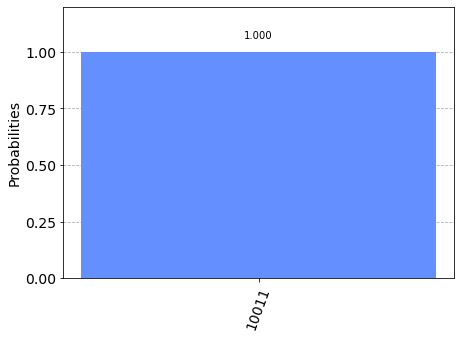

In [120]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)
qobj = assemble(qc_transpiled)

results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

In [121]:
number = 5
qc = QuantumCircuit(5)
qc.h([0,3,4])
qc.p(number*pi/4,0)
qc.p(number*pi/2,3)
qc.p(number*pi,4)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     └───┘└─────────┘
q_1: ────────────────
                     
q_2: ────────────────
     ┌───┐┌─────────┐
q_3: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_4: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

In [122]:
# Encode
qc.cx(0,1)

# CCX_L
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)

# CXX_L
qc.cx(0,1)
qc.cx(4,0)
qc.cx(0,1)

# CCX_L
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)
qc.cx(1,0)
qc.csx(0,4)

# H_L
qc.h(1)
qc.cry(pi,1,0)
qc.h([0,1])

# CP_L
qc.cp(-pi/4,0,3)
qc.cx(1,0)
qc.cp(-pi/4,0,3)
qc.cx(1,0)
qc.cp(-pi/4,0,3)
qc.h(3)

# CP_L
qc.cp(-pi/8,0,4)
qc.cx(1,0)
qc.cp(-pi/8,0,4)
qc.cx(1,0)
qc.cp(-pi/8,0,4)
qc.cp(-pi/2,3,4)
qc.h(4)

# EF
qc.cx(0,2)
qc.cx(1,2)

qc.measure_all()
qc.draw()

┌───┐┌─────────┐           ┌───┐      ┌───┐           ┌───┐           »
   q_0: ┤ H ├┤ P(5π/4) ├──■────■───┤ X ├──■───┤ X ├──■─────■──┤ X ├──■────■───»
        └───┘└─────────┘┌─┴─┐  │   └─┬─┘  │   └─┬─┘  │   ┌─┴─┐└─┬─┘┌─┴─┐  │   »
   q_1: ────────────────┤ X ├──┼─────■────┼─────■────┼───┤ X ├──┼──┤ X ├──┼───»
                        └───┘  │          │          │   └───┘  │  └───┘  │   »
   q_2: ───────────────────────┼──────────┼──────────┼──────────┼─────────┼───»
        ┌───┐┌─────────┐       │          │          │          │         │   »
   q_3: ┤ H ├┤ P(5π/2) ├───────┼──────────┼──────────┼──────────┼─────────┼───»
        ├───┤└┬───────┬┘     ┌─┴──┐     ┌─┴──┐     ┌─┴──┐       │       ┌─┴──┐»
   q_4: ┤ H ├─┤ P(5π) ├──────┤ Sx ├─────┤ Sx ├─────┤ Sx ├───────■───────┤ Sx ├»
        └───┘ └───────┘      └────┘     └────┘     └────┘               └────┘»
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐      ┌───┐           ┌───────┐┌───┐          ┌───┐          »
«   q_0: ┤ X ├──■───┤ X ├──■────────┤ Ry(π) ├┤ H ├─■────────┤ X ├─■────────»
«        └─┬─┘  │   └─┬─┘  │   ┌───┐└───┬───┘├───┤ │        └─┬─┘ │        »
«   q_1: ──■────┼─────■────┼───┤ H ├────■────┤ H ├─┼──────────■───┼────────»
«               │          │   └───┘         └───┘ │              │        »
«   q_2: ───────┼──────────┼───────────────────────┼──────────────┼────────»
«               │          │                       │P(-π/4)       │P(-π/4) »
«   q_3: ───────┼──────────┼───────────────────────■──────────────■────────»
«             ┌─┴──┐     ┌─┴──┐                                            »
«   q_4: ─────┤ Sx ├─────┤ Sx ├────────────────────────────────────────────»
«             └────┘     └────┘                                            »
«meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                          »
«        ┌───┐                         ┌───┐          ┌───┐                    »
«   q_0: ┤ X ├─■──────────────■────────┤ X ├─■────────┤ X ├─■────────────■─────»
«        └─┬─┘ │              │        └─┬─┘ │        └─┬─┘ │            │     »
«   q_1: ──■───┼──────────────┼──────────■───┼──────────■───┼────────────┼─────»
«              │              │              │              │          ┌─┴─┐   »
«   q_2: ──────┼──────────────┼──────────────┼──────────────┼──────────┤ X ├───»
«              │P(-π/4) ┌───┐ │              │              │          └───┘   »
«   q_3: ──────■────────┤ H ├─┼──────────────┼──────────────┼─────────■────────»
«                       └───┘ │P(-π/8)       │P(-π/8)       │P(-π/8)  │P(-π/2) »
«   q_4: ─────────────────────■──────────────■──────────────■─────────■────────»
«                                                                              »
«meas: 5/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«              ░ ┌─┐            
«   q_0: ──────░─┤M├────────────
«              ░ └╥┘┌─┐         
«   q_1: ──■───░──╫─┤M├─────────
«        ┌─┴─┐ ░  ║ └╥┘┌─┐      
«   q_2: ┤ X ├─░──╫──╫─┤M├──────
«        └───┘ ░  ║  ║ └╥┘┌─┐   
«   q_3: ──────░──╫──╫──╫─┤M├───
«        ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤ H ├─░──╫──╫──╫──╫─┤M├
«        └───┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/═════════╩══╩══╩══╩══╩═
«                 0  1  2  3  4

{'10011': 1024}


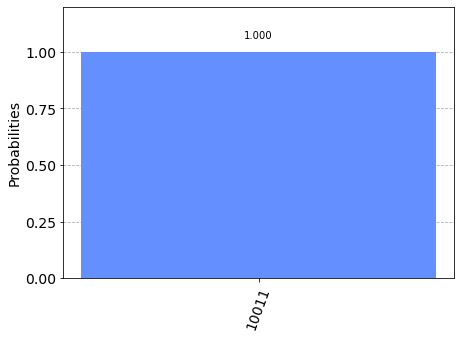

In [123]:
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim, optimization_level=0)
qobj = assemble(qc_transpiled)

results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 86
{'00000': 142, '00001': 59, '10000': 145, '10001': 26, '10010': 26, '10011': 77, '10100': 85, '10101': 23, '10110': 26, '10111': 109, '11000': 274, '11001': 69, '11010': 51, '11011': 140, '11100': 157, '11101': 57, '11110': 82, '11111': 177, '00010': 34, '00011': 101, '00100': 86, '00101': 31, '00110': 31, '00111': 109, '01000': 500, '01001': 158, '01010': 119, '01011': 364, '01100': 202, '01101': 86, '01110': 121, '01111': 333}


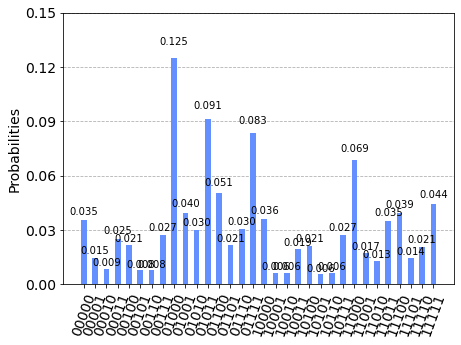

In [124]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_perth')
qc_perth = transpile(qc, backend, optimization_level=2, initial_layout=[5,3,1,4,6])

print("Circuit Depth :", qc_perth.depth())
results = backend.run(qc_perth).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 86
{'00000': 470, '00001': 47, '10000': 325, '10001': 49, '10010': 60, '10011': 750, '10100': 31, '10101': 234, '10110': 110, '10111': 43, '11000': 199, '11001': 17, '11010': 16, '11011': 85, '11100': 13, '11101': 62, '11110': 37, '11111': 6, '00010': 62, '00011': 742, '00100': 23, '00101': 143, '00110': 124, '00111': 38, '01000': 130, '01001': 22, '01010': 10, '01011': 48, '01100': 11, '01101': 51, '01110': 32, '01111': 10}


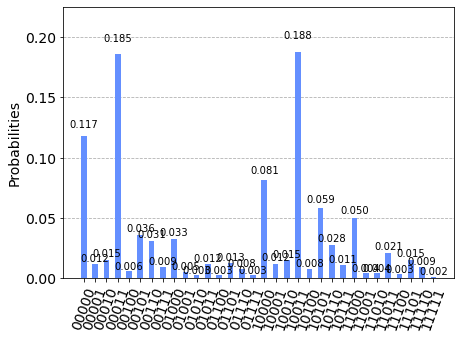

In [125]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_nairobi')
qc_nairobi = transpile(qc, backend, optimization_level=2, initial_layout=[5,3,1,4,6])

print("Circuit Depth :", qc_nairobi.depth())
results = backend.run(qc_nairobi).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 86
{'00000': 176, '00001': 16, '10000': 97, '10001': 5, '10010': 4, '10011': 80, '10100': 5, '10101': 53, '10110': 71, '10111': 11, '11000': 359, '11001': 16, '11010': 30, '11011': 278, '11100': 18, '11101': 230, '11110': 269, '11111': 42, '00010': 13, '00011': 287, '00100': 10, '00101': 177, '00110': 155, '00111': 19, '01000': 500, '01001': 22, '01010': 24, '01011': 296, '01100': 21, '01101': 288, '01110': 387, '01111': 41}


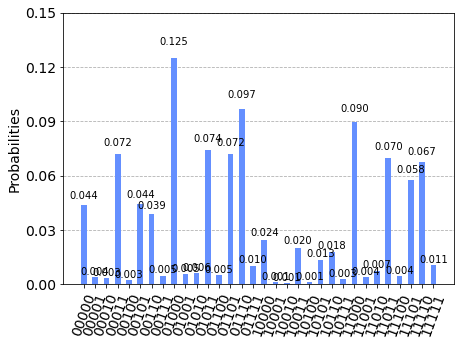

In [126]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibm_oslo')
qc_oslo = transpile(qc, backend, optimization_level=2, initial_layout=[5,3,1,4,6])

print("Circuit Depth :", qc_oslo.depth())
results = backend.run(qc_oslo).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 88
{'00000': 61, '00001': 52, '10000': 107, '10001': 75, '10010': 42, '10011': 793, '10100': 9, '10101': 178, '10110': 83, '10111': 33, '11000': 193, '11001': 35, '11010': 27, '11011': 336, '11100': 16, '11101': 58, '11110': 73, '11111': 22, '00010': 48, '00011': 584, '00100': 23, '00101': 125, '00110': 83, '00111': 29, '01000': 172, '01001': 33, '01010': 41, '01011': 444, '01100': 19, '01101': 70, '01110': 92, '01111': 44}


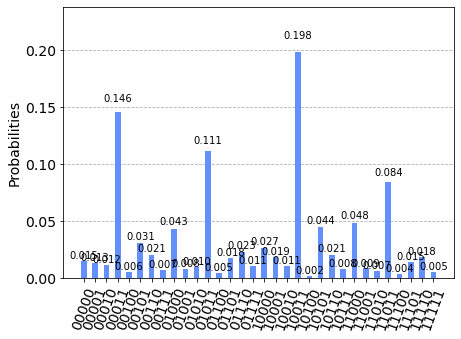

In [127]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_jakarta')
qc_jakarta = transpile(qc, backend, optimization_level=2, initial_layout=[5,3,1,4,6])

print("Circuit Depth :", qc_jakarta.depth())
results = backend.run(qc_jakarta).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

In [129]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_manila')
qc_manila = transpile(qc, backend, optimization_level=2, initial_layout=[2,3,4])

print("Circuit Depth :", qc_manila.depth())
results = backend.run(qc_manila).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

LayoutError: 'Integer list length (3) must equal number of qubits in circuit (5): [2, 3, 4].'

In [130]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_quito')
qc_quito = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,2,0])

print("Circuit Depth :", qc_quito.depth())
results = backend.run(qc_quito).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 84


IBMQBackendApiError: "Error submitting job: '401 Client Error: Unauthorized for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Invalid Access Token, Error code: 2407.'"

Circuit Depth : 84
{'00000': 188, '00001': 40, '10000': 188, '10001': 50, '10010': 52, '10011': 616, '10100': 21, '10101': 251, '10110': 153, '10111': 42, '11000': 267, '11001': 22, '11010': 41, '11011': 310, '11100': 20, '11101': 87, '11110': 128, '11111': 35, '00010': 53, '00011': 364, '00100': 27, '00101': 213, '00110': 135, '00111': 31, '01000': 238, '01001': 13, '01010': 35, '01011': 123, '01100': 24, '01101': 92, '01110': 119, '01111': 22}


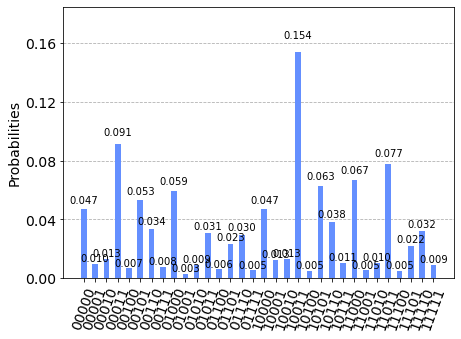

In [133]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_belem')
qc_belem = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,2,0])

print("Circuit Depth :", qc_belem.depth())
results = backend.run(qc_belem).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

Circuit Depth : 88
{'00000': 86, '00001': 29, '10000': 80, '10001': 16, '10010': 91, '10011': 427, '10100': 38, '10101': 154, '10110': 120, '10111': 48, '11000': 247, '11001': 26, '11010': 105, '11011': 507, '11100': 28, '11101': 102, '11110': 139, '11111': 43, '00010': 80, '00011': 419, '00100': 56, '00101': 147, '00110': 122, '00111': 36, '01000': 165, '01001': 14, '01010': 62, '01011': 285, '01100': 47, '01101': 99, '01110': 136, '01111': 46}


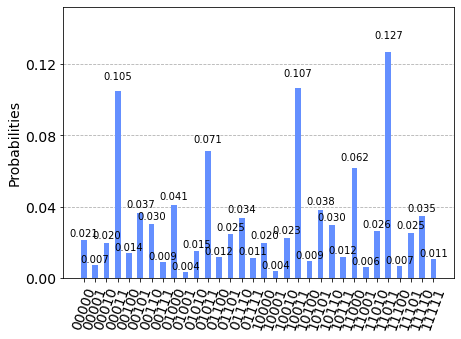

In [134]:
from qiskit import IBMQ

backend = my_provider.get_backend('ibmq_lima')
qc_lima = transpile(qc, backend, optimization_level=2, initial_layout=[1,3,4,2,0])

print("Circuit Depth :", qc_lima.depth())
results = backend.run(qc_lima).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)